Nesse novo algoritmo foram incluídos dados reais de demanda, porém meu modelo precisou de algumas modificações:
- Passei a utilizar valores binários para o funcionamento dos motores a cada hora, 1 para motor ligado naquele instante (antes valores aleatórios de minutos de funcionamento eram gerados)
- Considero apenas um motor (por simplicidade)
- Antes o cálculo de custo era diário e aqui está feito o cálculo para um mês, para atender aos valores da demanda utilizada
- São 720 dados, que representam os 720 genes de cada indivíduo, pois considero um mês de 30 dias
- A tarifa não abrange valores diferentes para o fim de semana (também por simplicidade)
- Testes foram feitos e não constam aqui pois, se entendi bem, ficarão para a apresentação
- Muitas das modificações se fizeram necessárias para tornar o código menos custoso e por orientações que recebi

In [386]:
# Bibliotecas necessárias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [387]:
# Leitura dos dados

demandareal = pd.read_excel("setembro2021.xlsx")
demandareal = demandareal["CONSUMO"].values

In [388]:
# Parâmetros
volume_maximo = 5
volume_minimo = 2
vazao = 2
probcruz = 0.6
probmut = 0.02
num_individuals = 150

In [389]:
# Função objetivo a ser minimizada, com penalidade de demanda

def fitness(individuo, demanda, volume_maximo, volume_minimo, custo, vazao, check=0):
    volume = volume_maximo

    fit = np.sum(custo[individuo])
    volume_t = individuo * vazao - demanda
    volume_t = np.array([volume] + list(volume_t))
    volume_t = np.cumsum(volume_t)

    # Verifica as restrições de volume mínimo e máximo
    volume_penal = np.maximum(volume_t - volume_maximo, 0) + np.maximum(volume_minimo - volume_t, 0)
    #volume_penal *= 10  # Multiplica a penalidade pelo fator de amplificação desejado


    if check == 1:
        print(volume_penal, fit, len(volume_penal))

    # Calcula a aptidão considerando as restrições
    fit += np.sum(volume_penal)
    return fit

In [390]:
# Definição da tarifa:

def S(t):
    hora = t % 24  # Calcula a hora do dia a partir do índice t
    if hora >= 17 and hora < 21:  # Horário de ponta
        return 1.63527
    else:  # Horário fora de ponta
        return 0.62124
        
tarifa = np.array([S(i) for i in range(len(demandareal))])

In [391]:
# Seleção

def selecao(populacao, aptidao):
    aid = np.random.choice(len(populacao), size=2, replace=False)
    bid = np.random.choice(len(populacao), size=2, replace=False)
    
    aid = aid[np.argmax(aptidao[aid])]
    bid = bid[np.argmax(aptidao[bid])]
    a = populacao[aid]
    b = populacao[bid]
    apt = aptidao[aid]
    bpt = aptidao[bid]
    
    return np.array([a, b]), np.array([apt, bpt])

In [392]:
# Cruzamento

def cruzamento(pais, probcruz):
    if np.random.rand() < probcruz:
        filho = np.empty_like(pais[0])
        for i in range(len(filho)):
            if np.random.rand() < 0.5:
                filho[i] = pais[0][i]
            else:
                filho[i] = pais[1][i]
    else:
        filho = pais[np.random.randint(0, 2)]
    
    return filho

In [393]:
# Mutação

def mutacao(individuo, probmut):
    n = len(individuo)
    copia = np.copy(individuo)
    num_mutacoes = int(probmut * n)
    idx = np.random.choice(n, size=num_mutacoes, replace=False)

    for i in range(num_mutacoes):
        gene = idx[i]
        novo_valor = np.random.uniform(0, 1)
        novo_gene = 0 if novo_valor <= 0.5 else 1
        copia[gene] = novo_gene

    return copia

In [394]:
# Algoritmo Genético

def AG(demandareal, tarifa, volume_maximo, volume_minimo, vazao, probcruz, probmut, num_individuals):
    
    np.random.seed(424)
    num_genes = len(demandareal)
    populacao = np.random.choice([True, False], size=(num_individuals, num_genes))
    
    F = lambda individuo: fitness(individuo, demandareal, volume_maximo, volume_minimo, tarifa, vazao)
    aptidao = np.array([F(individuo) for individuo in populacao])

    historico = []
    contador = 0

    while True:
        
        pais,apt = selecao(populacao,aptidao)

        filho = cruzamento(pais,probcruz)
        filho = mutacao(filho,probmut)

        populacao[np.argmax(aptidao),:] = filho
        aptidao[np.argmax(aptidao)] = F(filho)

        historico.append([aptidao[np.argmin(aptidao)],np.mean(aptidao)])

        if(np.mean(aptidao) - aptidao[np.argmin(aptidao)] < 1e-5):
            break
        contador += 1
        if(contador%1000 == 0):
            print(aptidao[np.argmin(aptidao)])
        if(aptidao[np.argmin(aptidao)] < 6000):
            break
    melhor_solucao = populacao[np.argmin(aptidao)]
    num_1s = np.sum(melhor_solucao)
    num_0s = len(melhor_solucao) - num_1s
    print("Número de 1s:", num_1s)
    print("Número de 0s:", num_0s)

    historico = np.array(historico)
    return historico, populacao[np.argmin(aptidao)]

In [435]:
# Análise de diversidade do meu projeto

from collections import Counter
import numpy as np

def calcular_entropia_shannon(populacao):
    total = populacao.shape[0]
    proporcoes = np.sum(populacao, axis=0) / total
    entropias = -np.sum(proporcoes * np.log2(proporcoes + 1e-10))
    return entropias

def calcular_diversidade_fenotipica(populacao, valores_fitness):
    num_individuos = populacao.shape[0]
    contador = Counter(tuple(np.array2string(individuo, separator='')) for individuo in populacao if individuo.any())
    proporcao_unicos = len(contador) / num_individuos
    return proporcao_unicos



def plot_diversidade(diversidades):
    gerações = range(len(diversidades))
    plt.plot(gerações, diversidades)
    plt.xlabel('Geração')
    plt.ylabel('Diversidade')
    plt.title('Grau de Diversidade ao Longo das Gerações')
    plt.show()

In [403]:
start_time = time.time()

dados,melhor_valor = AG(demandareal, tarifa, volume_maximo, volume_minimo, vazao, probcruz, probmut, num_individuals)

resultado = fitness(melhor_valor, demandareal, volume_maximo, volume_minimo, tarifa, vazao)

end_time = time.time()
execution_time = end_time - start_time

print("Resultado do algoritmo genético:", resultado)
print("Tempo de execução:", execution_time, "segundos")

165048.01271000013
149542.59792000015
127503.17110000012
109099.09220000013
95975.64314000012
82238.9248600001
72881.96633000013
57923.82705000012
50796.49975000007
45361.09131000006
34973.93000000001
30446.04194000011
28757.48186000007
23287.132490000025
20601.83613999998
14741.754589999977
14741.754589999977
13363.25978999997
10820.689399999967
9435.178239999945
7109.484990000006
6558.597859999977
Número de 1s: 96
Número de 0s: 624
Resultado do algoritmo genético: 4728.271579999992
Tempo de execução: 21.906286478042603 segundos


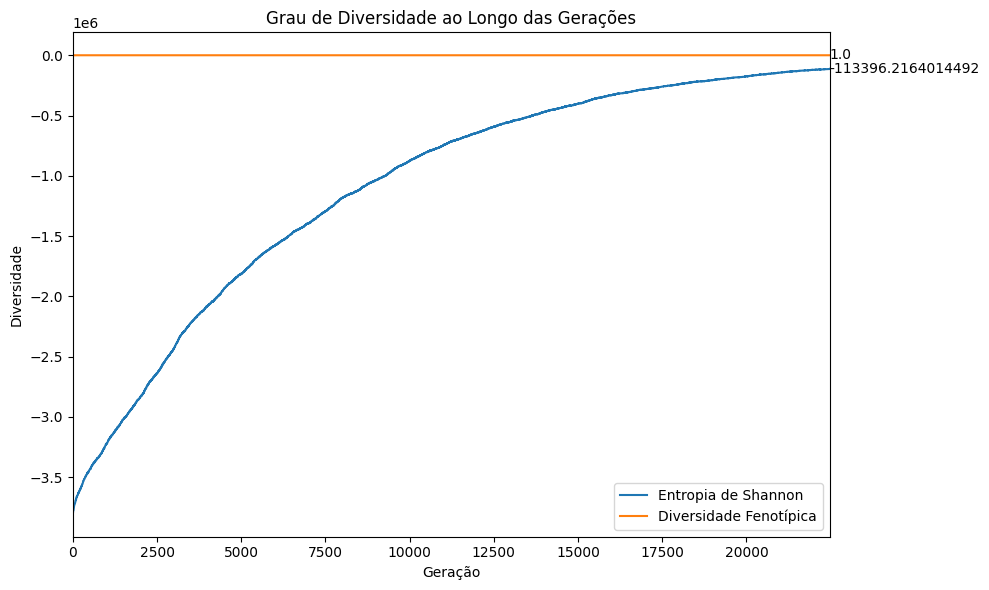

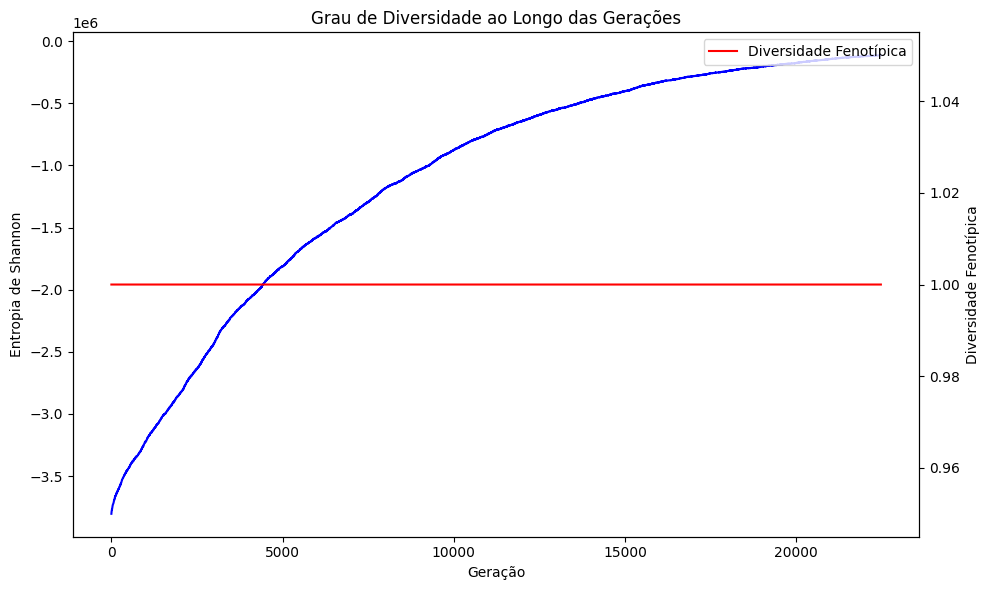

In [468]:
import matplotlib.pyplot as plt

# Acompanhar a diversidade ao longo das gerações
diversidades_entropia = []
diversidades_fenotipicas = []

for geracao in dados:
    populacao_geracao = geracao[1:]  # População da geração atual
    valores_fitness_geracao = [fitness(np.where(individuo)[0], demandareal, volume_maximo, volume_minimo, tarifa, vazao) for individuo in populacao_geracao]
    
    diversidade_entropia = calcular_entropia_shannon(populacao_geracao)
    diversidade_fenotipica = calcular_diversidade_fenotipica(populacao_geracao, valores_fitness_geracao)
    
    diversidades_entropia.append(diversidade_entropia)
    diversidades_fenotipicas.append(diversidade_fenotipica)

# Plotar o grau de diversidade ao longo das gerações
geracoes = range(len(dados))
plt.figure(figsize=(10, 6))  # Ajuste o tamanho da figura conforme necessário
plt.plot(geracoes, diversidades_entropia, label='Entropia de Shannon')
plt.plot(geracoes, diversidades_fenotipicas, label='Diversidade Fenotípica')

plt.xlim(0, len(dados) - 1)

# Adicionar valores finais aos eixos x e y
plt.text(len(dados) - 1, diversidades_entropia[-1], str(diversidades_entropia[-1]), ha='left', va='center')
plt.text(len(dados) - 1, diversidades_fenotipicas[-1], str(diversidades_fenotipicas[-1]), ha='left', va='center')

plt.xlabel('Geração')
plt.ylabel('Diversidade')
plt.title('Grau de Diversidade ao Longo das Gerações')
plt.legend()
plt.tight_layout()  # Ajuste a organização dos elementos do gráfico
plt.show()

# Plotar o grau de diversidade ao longo das gerações
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(geracoes, diversidades_entropia, label='Entropia de Shannon', color='blue')
ax1.set_ylabel('Entropia de Shannon')
ax1.set_xlabel('Geração')

# Configurar segundo eixo y
ax2 = ax1.twinx()
ax2.plot(geracoes, diversidades_fenotipicas, label='Diversidade Fenotípica', color='red')
ax2.set_ylabel('Diversidade Fenotípica')

plt.title('Grau de Diversidade ao Longo das Gerações')
plt.legend()
plt.tight_layout()
plt.show()

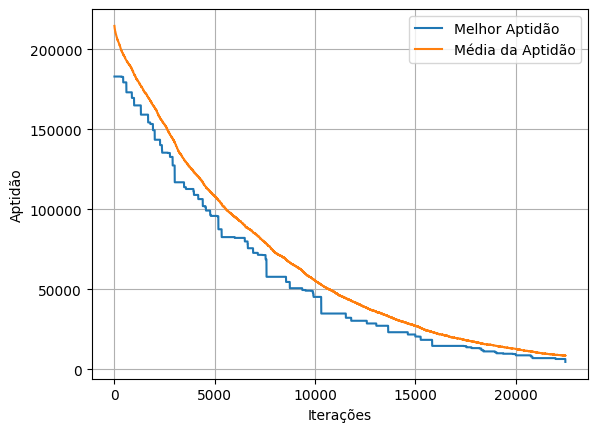

In [467]:
plt.plot(range(len(dados.T[0])), dados.T[0], label='Melhor Aptidão')
plt.plot(range(len(dados.T[0])), dados.T[1], label='Média da Aptidão')
plt.xlabel('Iterações')
plt.ylabel('Aptidão')
plt.legend()
plt.grid(True)
plt.show()

In [398]:
fitness(melhor_valor, demandareal, volume_maximo, volume_minimo, tarifa, vazao,1)
print(populacao)


[ 0.    0.    0.    0.    0.    0.    2.    1.96  1.86  1.71  1.58  1.49
  1.42  1.38  1.34  1.31  1.29  1.26  1.24  1.21  0.57  0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.51  0.43  0.35
  0.28  0.22  0.21  0.21  0.21  0.21  0.21  0.    0.    1.01  1.62  1.65
  1.65  1.65  1.65  1.65  1.65  0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.46  2.05  3.32  3.45  3.45
  3.45  3.45  3.45  3.45  3.45  3.45  3.45  3.45  3.45  3.45  3.45  3.45
  3.45  3.45  3.45  3.45  3.45  3.45  3.45  3.45  1.45  1.45  1.45  1.45
  1.45  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.18  1.8   2.68  2.97  3.04  3.07  3.11  3.14  3.14
  3.14  3.14  3.14  3.14  3.14  3.14  3.14  3.14  3.14  3.14  3.14  1.14
  0.    0.    0.    0.    0.    1.86  1.86  1.86  1.86  1.86 